# Treatment Effect Analysis

How much does treatment benefit individual simulants? This notebook uses matched
simulant comparison (via CRN) between the `bbbm_testing` and `bbbm_testing_and_treatment`
scenarios to measure:

1. **Additional preclinical years** a typical treated simulant gains
2. **DALYs averted** per treatment
3. **Whether the effect changes over time** (by treatment cohort year)

### Method

Vivarium uses Common Random Numbers (CRN), so the same simulant IDs exist in both
scenarios. By running both step-by-step and recording when each simulant transitions
out of BBBM, we can compute the per-simulant delay in progression caused by treatment.

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm.auto import tqdm
from vivarium import InteractiveContext

SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000
STEP_SIZE_DAYS = 182
STEP_SIZE_YEARS = STEP_SIZE_DAYS / 365.25

BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'
DISEASE_COL = 'alzheimers_disease_and_other_dementias'

TARGET_YEAR = 2070  # run far enough for treatment effects to fully play out

# Disability weights from artifact (draw_0)
DW_BBBM = 0.0
DW_MCI = 0.031   # constant across ages
DW_DEMENTIA = 0.31  # ~average for ages 65-80

# Treatment relative risk from artifact (draw_0)
TREATMENT_RR = 0.528

## Run both scenarios, tracking per-simulant BBBM exit times

For each scenario, we track:
- When each simulant **first enters** BBBM
- When each simulant **exits** BBBM (transitions to MCI or dies)
- Per-step disease state counts for aggregate analysis
- Treatment state (treatment scenario only)

In [2]:
def run_scenario_with_tracking(scenario, target_year=TARGET_YEAR):
    """Run a scenario and track per-simulant BBBM exit times + per-step aggregates."""
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    # Track which simulants are currently in BBBM
    in_bbbm = set()  # simulant IDs currently in BBBM
    bbbm_enter_time = {}  # simulant_id -> first BBBM entry timestamp
    bbbm_exit_time = {}   # simulant_id -> first BBBM exit timestamp
    bbbm_exit_to = {}     # simulant_id -> state they exited to (MCI or dead)
    treatment_start = {}  # simulant_id -> timestamp they entered treatment pipeline

    # Per-step aggregate snapshots
    snapshots = []

    with tqdm(total=est_steps, desc=scenario.replace('bbbm_', ''), unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time

            # Current BBBM simulants
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])

            # New BBBM entries (weren't in BBBM before, now are)
            new_bbbm = currently_bbbm - in_bbbm
            for sid in new_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t

            # BBBM exits (were in BBBM, now aren't — either transitioned or died)
            exited = in_bbbm - currently_bbbm
            all_alive_ids = set(alive.index)
            for sid in exited:
                if sid not in bbbm_exit_time:  # only record first exit
                    bbbm_exit_time[sid] = t
                    if sid in all_alive_ids:
                        bbbm_exit_to[sid] = alive.loc[sid, DISEASE_COL]
                    else:
                        bbbm_exit_to[sid] = 'dead'

            in_bbbm = currently_bbbm

            # Track treatment entries
            if scenario == 'bbbm_testing_and_treatment':
                active_states = ['waiting_for_treatment', 'treatment_effect',
                                 'waning_effect', 'no_effect_after_treatment']
                in_treat = alive.index[alive['treatment'].isin(active_states)]
                for sid in in_treat:
                    if sid not in treatment_start:
                        treatment_start[sid] = t

            # Aggregate snapshot
            disease = alive[DISEASE_COL].value_counts()
            treat_states = alive['treatment'].value_counts()
            snapshots.append({
                'time': t,
                'year': t.year + t.day_of_year / 365.25,
                'n_alive': len(alive),
                'n_bbbm': disease.get(BBBM_STATE, 0),
                'n_mci': disease.get(MCI_STATE, 0),
                'n_dementia': disease.get(DEMENTIA_STATE, 0),
                'n_treatment_effect': treat_states.get('treatment_effect', 0),
                'n_waning_effect': treat_states.get('waning_effect', 0),
                'n_in_pipeline': sum(treat_states.get(s, 0) for s in
                    ['waiting_for_treatment', 'treatment_effect',
                     'waning_effect', 'no_effect_after_treatment']),
            })
            pbar.update(1)
        pbar.total = len(snapshots)
        pbar.refresh()

    return {
        'snapshots': pd.DataFrame(snapshots),
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'treatment_start': treatment_start,
    }

In [3]:
print('Running testing-only scenario...')
test_data = run_scenario_with_tracking('bbbm_testing')
print(f'  {len(test_data["bbbm_exit_time"])} BBBM exits recorded')

print('\nRunning testing+treatment scenario...')
treat_data = run_scenario_with_tracking('bbbm_testing_and_treatment')
print(f'  {len(treat_data["bbbm_exit_time"])} BBBM exits recorded')
print(f'  {len(treat_data["treatment_start"])} simulants entered treatment')

Running testing-only scenario...


/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


2026-02-07 21:40:08.049 | INFO     | simulation_1-artifact_manager:79 - Running simulation from artifact located at /home/abie/vivarium_csu_alzheimers/united_states_of_america.hdf.


2026-02-07 21:40:08.050 | INFO     | simulation_1-artifact_manager:80 - Artifact base filter terms are ['draw == 0'].


2026-02-07 21:40:08.051 | INFO     | simulation_1-artifact_manager:81 - Artifact additional filter terms are None.


2026-02-07 21:40:10.353 | INFO     | simulation_1-results_context:129 - The following stratifications are registered but not used by any observers: 
['current_year', 'semester']


2026-02-07 21:40:10.473 | WARNING  | simulation_1-resource_manager:176 - Resource stream.alzheimers_disease_and_other_dementias_initial_states is not produced by any component but is needed to compute (column.alzheimers_disease_and_other_dementias).


2026-02-07 21:40:10.476 | WARNING  | simulation_1-resource_manager:176 - Resource column.treatment_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.treatment_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-07 21:40:10.478 | WARNING  | simulation_1-resource_manager:176 - Resource column.waning_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.waning_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-07 21:40:10.480 | WARNING  | simulation_1-resource_manager:176 - Resource stream.treatment_initial_states is not produced by any component but is needed to compute (null.0).


testing:   0%|          | 0/97 [00:00<?, ?step/s]

2026-02-07 21:40:11.922 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-01-01 00:00:00


2026-02-07 21:40:17.120 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-07-02 00:00:00


2026-02-07 21:40:22.026 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2022-12-31 00:00:00


2026-02-07 21:40:27.061 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-07-01 00:00:00


2026-02-07 21:40:32.079 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2023-12-30 00:00:00


2026-02-07 21:40:36.002 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-06-29 00:00:00


2026-02-07 21:40:40.499 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2024-12-28 00:00:00


2026-02-07 21:40:45.650 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-06-28 00:00:00


2026-02-07 21:40:50.244 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-12-27 00:00:00


2026-02-07 21:40:53.398 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2026-06-27 00:00:00


2026-02-07 21:40:59.105 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2026-12-26 00:00:00


2026-02-07 21:41:04.437 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2027-06-26 00:00:00


2026-02-07 21:41:09.299 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2027-12-25 00:00:00


2026-02-07 21:41:15.571 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2028-06-24 00:00:00


2026-02-07 21:41:20.327 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2028-12-23 00:00:00


2026-02-07 21:41:25.816 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2029-06-23 00:00:00


2026-02-07 21:41:30.469 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2029-12-22 00:00:00


2026-02-07 21:41:36.347 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2030-06-22 00:00:00


2026-02-07 21:41:41.366 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2030-12-21 00:00:00


2026-02-07 21:41:47.682 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2031-06-21 00:00:00


2026-02-07 21:41:56.156 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2031-12-20 00:00:00


2026-02-07 21:42:02.961 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2032-06-19 00:00:00


2026-02-07 21:42:11.395 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2032-12-18 00:00:00


2026-02-07 21:42:16.868 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2033-06-18 00:00:00


2026-02-07 21:42:22.949 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2033-12-17 00:00:00


2026-02-07 21:42:29.465 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2034-06-17 00:00:00


2026-02-07 21:42:36.892 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2034-12-16 00:00:00


2026-02-07 21:42:43.177 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2035-06-16 00:00:00


2026-02-07 21:42:51.112 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2035-12-15 00:00:00


2026-02-07 21:43:01.271 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2036-06-14 00:00:00


2026-02-07 21:43:10.579 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2036-12-13 00:00:00


2026-02-07 21:43:18.764 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2037-06-13 00:00:00


2026-02-07 21:43:27.145 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2037-12-12 00:00:00


2026-02-07 21:43:34.491 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2038-06-12 00:00:00


2026-02-07 21:43:44.693 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2038-12-11 00:00:00


2026-02-07 21:43:52.447 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2039-06-11 00:00:00


2026-02-07 21:44:01.086 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2039-12-10 00:00:00


2026-02-07 21:44:09.220 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2040-06-09 00:00:00


2026-02-07 21:44:17.924 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2040-12-08 00:00:00


2026-02-07 21:44:26.935 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2041-06-08 00:00:00


2026-02-07 21:44:36.594 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2041-12-07 00:00:00


2026-02-07 21:44:45.530 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2042-06-07 00:00:00


2026-02-07 21:44:53.797 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2042-12-06 00:00:00


2026-02-07 21:45:03.675 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2043-06-06 00:00:00


2026-02-07 21:45:14.188 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2043-12-05 00:00:00


2026-02-07 21:45:21.417 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2044-06-04 00:00:00


2026-02-07 21:45:29.311 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2044-12-03 00:00:00


2026-02-07 21:45:36.491 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2045-06-03 00:00:00


2026-02-07 21:45:46.410 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2045-12-02 00:00:00


2026-02-07 21:45:56.087 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2046-06-02 00:00:00


2026-02-07 21:46:05.937 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2046-12-01 00:00:00


2026-02-07 21:46:17.052 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2047-06-01 00:00:00


2026-02-07 21:46:28.181 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2047-11-30 00:00:00


2026-02-07 21:46:34.754 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2048-05-30 00:00:00


2026-02-07 21:46:43.006 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2048-11-28 00:00:00


2026-02-07 21:46:53.728 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2049-05-29 00:00:00


2026-02-07 21:47:04.732 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2049-11-27 00:00:00


2026-02-07 21:47:16.643 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2050-05-28 00:00:00


2026-02-07 21:47:26.502 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2050-11-26 00:00:00


2026-02-07 21:47:38.088 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2051-05-27 00:00:00


2026-02-07 21:47:47.547 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2051-11-25 00:00:00


2026-02-07 21:47:59.122 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2052-05-25 00:00:00


2026-02-07 21:48:11.585 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2052-11-23 00:00:00


2026-02-07 21:48:24.199 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2053-05-24 00:00:00


2026-02-07 21:48:37.007 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2053-11-22 00:00:00


2026-02-07 21:48:48.461 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2054-05-23 00:00:00


2026-02-07 21:49:01.184 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2054-11-21 00:00:00


2026-02-07 21:49:12.776 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2055-05-22 00:00:00


2026-02-07 21:49:21.607 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2055-11-20 00:00:00


2026-02-07 21:49:31.949 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2056-05-20 00:00:00


2026-02-07 21:49:41.922 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2056-11-18 00:00:00


2026-02-07 21:49:53.087 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2057-05-19 00:00:00


2026-02-07 21:50:03.780 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2057-11-17 00:00:00


2026-02-07 21:50:18.208 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2058-05-18 00:00:00


2026-02-07 21:50:31.685 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2058-11-16 00:00:00


2026-02-07 21:50:45.523 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2059-05-17 00:00:00


2026-02-07 21:50:58.964 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2059-11-15 00:00:00


2026-02-07 21:51:11.801 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2060-05-15 00:00:00


2026-02-07 21:51:25.854 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2060-11-13 00:00:00


2026-02-07 21:51:40.031 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2061-05-14 00:00:00


2026-02-07 21:51:54.921 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2061-11-12 00:00:00


2026-02-07 21:52:08.830 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2062-05-13 00:00:00


2026-02-07 21:52:21.736 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2062-11-11 00:00:00


2026-02-07 21:52:35.891 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2063-05-12 00:00:00


2026-02-07 21:52:48.492 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2063-11-10 00:00:00


2026-02-07 21:53:01.643 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2064-05-10 00:00:00


2026-02-07 21:53:15.183 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2064-11-08 00:00:00


2026-02-07 21:53:29.082 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2065-05-09 00:00:00


2026-02-07 21:53:40.520 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2065-11-07 00:00:00


2026-02-07 21:53:52.124 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2066-05-08 00:00:00


2026-02-07 21:54:06.166 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2066-11-06 00:00:00


2026-02-07 21:54:19.130 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2067-05-07 00:00:00


2026-02-07 21:54:30.340 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2067-11-05 00:00:00


2026-02-07 21:54:43.699 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2068-05-05 00:00:00


2026-02-07 21:54:57.973 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2068-11-03 00:00:00


2026-02-07 21:55:12.884 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2069-05-04 00:00:00


2026-02-07 21:55:22.420 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2069-11-02 00:00:00


  86013 BBBM exits recorded

Running testing+treatment scenario...
2026-02-07 21:55:34.088 | INFO     | simulation_2-artifact_manager:79 - Running simulation from artifact located at /home/abie/vivarium_csu_alzheimers/united_states_of_america.hdf.


2026-02-07 21:55:34.089 | INFO     | simulation_2-artifact_manager:80 - Artifact base filter terms are ['draw == 0'].


2026-02-07 21:55:34.090 | INFO     | simulation_2-artifact_manager:81 - Artifact additional filter terms are None.


2026-02-07 21:55:35.895 | INFO     | simulation_2-results_context:129 - The following stratifications are registered but not used by any observers: 
['current_year', 'semester']


2026-02-07 21:55:35.980 | WARNING  | simulation_2-resource_manager:176 - Resource stream.alzheimers_disease_and_other_dementias_initial_states is not produced by any component but is needed to compute (column.alzheimers_disease_and_other_dementias).


2026-02-07 21:55:35.981 | WARNING  | simulation_2-resource_manager:176 - Resource column.treatment_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.treatment_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-07 21:55:35.982 | WARNING  | simulation_2-resource_manager:176 - Resource column.waning_effect.dwell_time is not produced by any component but is needed to compute (value_modifier.waning_effect.dwell_time.1.treatment.modify_dwell_time).


2026-02-07 21:55:35.982 | WARNING  | simulation_2-resource_manager:176 - Resource stream.treatment_initial_states is not produced by any component but is needed to compute (null.0).


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

2026-02-07 21:55:36.937 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-01-01 00:00:00


2026-02-07 21:55:40.399 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-07-02 00:00:00


2026-02-07 21:55:44.671 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2022-12-31 00:00:00


2026-02-07 21:55:49.744 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-07-01 00:00:00


2026-02-07 21:55:54.740 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2023-12-30 00:00:00


2026-02-07 21:56:00.147 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-06-29 00:00:00


2026-02-07 21:56:04.754 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2024-12-28 00:00:00


2026-02-07 21:56:08.845 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-06-28 00:00:00


2026-02-07 21:56:14.291 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-12-27 00:00:00


2026-02-07 21:56:19.337 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2026-06-27 00:00:00


2026-02-07 21:56:24.058 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2026-12-26 00:00:00


2026-02-07 21:56:28.552 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2027-06-26 00:00:00


2026-02-07 21:56:34.596 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2027-12-25 00:00:00


2026-02-07 21:56:39.500 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2028-06-24 00:00:00


2026-02-07 21:56:46.300 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2028-12-23 00:00:00


2026-02-07 21:56:51.936 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2029-06-23 00:00:00


2026-02-07 21:56:57.098 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2029-12-22 00:00:00


2026-02-07 21:57:02.983 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2030-06-22 00:00:00


2026-02-07 21:57:09.098 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2030-12-21 00:00:00


2026-02-07 21:57:15.408 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2031-06-21 00:00:00


2026-02-07 21:57:21.728 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2031-12-20 00:00:00


2026-02-07 21:57:32.718 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2032-06-19 00:00:00


2026-02-07 21:57:40.175 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2032-12-18 00:00:00


2026-02-07 21:57:47.672 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2033-06-18 00:00:00


2026-02-07 21:57:55.002 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2033-12-17 00:00:00


2026-02-07 21:58:03.107 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2034-06-17 00:00:00


2026-02-07 21:58:13.609 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2034-12-16 00:00:00


2026-02-07 21:58:21.931 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2035-06-16 00:00:00


2026-02-07 21:58:31.330 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2035-12-15 00:00:00


2026-02-07 21:58:41.967 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2036-06-14 00:00:00


2026-02-07 21:58:50.436 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2036-12-13 00:00:00


2026-02-07 21:58:59.484 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2037-06-13 00:00:00


2026-02-07 21:59:09.321 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2037-12-12 00:00:00


2026-02-07 21:59:17.723 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2038-06-12 00:00:00


2026-02-07 21:59:27.048 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2038-12-11 00:00:00


2026-02-07 21:59:35.232 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2039-06-11 00:00:00


2026-02-07 21:59:43.862 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2039-12-10 00:00:00


2026-02-07 21:59:51.435 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2040-06-09 00:00:00


2026-02-07 22:00:00.964 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2040-12-08 00:00:00


2026-02-07 22:00:11.312 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2041-06-08 00:00:00


2026-02-07 22:00:20.923 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2041-12-07 00:00:00


2026-02-07 22:00:32.170 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2042-06-07 00:00:00


2026-02-07 22:00:50.309 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2042-12-06 00:00:00


2026-02-07 22:01:01.942 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2043-06-06 00:00:00


2026-02-07 22:01:14.213 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2043-12-05 00:00:00


2026-02-07 22:01:24.320 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2044-06-04 00:00:00


2026-02-07 22:01:33.408 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2044-12-03 00:00:00


2026-02-07 22:01:44.674 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2045-06-03 00:00:00


2026-02-07 22:01:56.027 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2045-12-02 00:00:00


2026-02-07 22:02:08.663 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2046-06-02 00:00:00


2026-02-07 22:02:20.315 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2046-12-01 00:00:00


2026-02-07 22:02:34.025 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2047-06-01 00:00:00


2026-02-07 22:02:46.288 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2047-11-30 00:00:00


2026-02-07 22:02:58.156 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2048-05-30 00:00:00


2026-02-07 22:03:12.109 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2048-11-28 00:00:00


2026-02-07 22:03:25.340 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2049-05-29 00:00:00


2026-02-07 22:03:38.023 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2049-11-27 00:00:00


2026-02-07 22:03:51.104 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2050-05-28 00:00:00


2026-02-07 22:04:03.767 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2050-11-26 00:00:00


2026-02-07 22:04:16.368 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2051-05-27 00:00:00


2026-02-07 22:04:32.031 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2051-11-25 00:00:00


2026-02-07 22:04:45.528 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2052-05-25 00:00:00


2026-02-07 22:04:59.639 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2052-11-23 00:00:00


2026-02-07 22:05:15.332 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2053-05-24 00:00:00


2026-02-07 22:05:32.431 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2053-11-22 00:00:00


2026-02-07 22:05:49.932 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2054-05-23 00:00:00


2026-02-07 22:06:06.020 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2054-11-21 00:00:00


2026-02-07 22:06:21.231 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2055-05-22 00:00:00


2026-02-07 22:06:37.008 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2055-11-20 00:00:00


2026-02-07 22:06:53.673 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2056-05-20 00:00:00


2026-02-07 22:07:08.898 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2056-11-18 00:00:00


2026-02-07 22:07:25.860 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2057-05-19 00:00:00


2026-02-07 22:07:46.342 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2057-11-17 00:00:00


2026-02-07 22:08:03.161 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2058-05-18 00:00:00


2026-02-07 22:08:17.863 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2058-11-16 00:00:00


2026-02-07 22:08:34.471 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2059-05-17 00:00:00


2026-02-07 22:08:51.922 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2059-11-15 00:00:00


2026-02-07 22:09:06.039 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2060-05-15 00:00:00


2026-02-07 22:09:19.873 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2060-11-13 00:00:00


2026-02-07 22:09:35.913 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2061-05-14 00:00:00


2026-02-07 22:09:52.388 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2061-11-12 00:00:00


2026-02-07 22:10:08.835 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2062-05-13 00:00:00


2026-02-07 22:10:24.087 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2062-11-11 00:00:00


2026-02-07 22:10:40.585 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2063-05-12 00:00:00


2026-02-07 22:10:56.587 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2063-11-10 00:00:00


2026-02-07 22:11:14.568 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2064-05-10 00:00:00


2026-02-07 22:11:29.331 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2064-11-08 00:00:00


2026-02-07 22:11:48.000 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2065-05-09 00:00:00


2026-02-07 22:12:04.620 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2065-11-07 00:00:00


2026-02-07 22:12:22.346 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2066-05-08 00:00:00


2026-02-07 22:12:41.799 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2066-11-06 00:00:00


2026-02-07 22:12:58.936 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2067-05-07 00:00:00


2026-02-07 22:13:13.570 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2067-11-05 00:00:00


2026-02-07 22:13:28.307 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2068-05-05 00:00:00


2026-02-07 22:13:41.681 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2068-11-03 00:00:00


2026-02-07 22:13:57.002 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2069-05-04 00:00:00


2026-02-07 22:14:10.398 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2069-11-02 00:00:00


  85783 BBBM exits recorded
  3969 simulants entered treatment


## Matched Simulant Comparison

For each treated simulant, compute how long they stayed in BBBM in each scenario.
The difference is the additional preclinical time gained from treatment.

In [4]:
# Build a DataFrame of treated simulants with matched BBBM durations
sim_end = treat_data['snapshots']['time'].iloc[-1]

rows = []
for sid in treat_data['treatment_start']:
    # BBBM duration in treatment scenario
    enter_treat = treat_data['bbbm_enter_time'].get(sid)
    exit_treat = treat_data['bbbm_exit_time'].get(sid)
    if enter_treat is None:
        continue  # skip if never in BBBM (shouldn't happen)
    # If still in BBBM at end of sim, use sim end as censored exit
    censored_treat = exit_treat is None
    exit_treat_t = exit_treat if exit_treat else sim_end
    dur_treat = (exit_treat_t - enter_treat).days / 365.25

    # BBBM duration in testing-only scenario (matched by ID)
    enter_test = test_data['bbbm_enter_time'].get(sid)
    exit_test = test_data['bbbm_exit_time'].get(sid)
    if enter_test is None:
        continue  # simulant doesn't exist in testing-only (rare)
    censored_test = exit_test is None
    exit_test_t = exit_test if exit_test else sim_end
    dur_test = (exit_test_t - enter_test).days / 365.25

    rows.append({
        'simulant_id': sid,
        'treatment_start': treat_data['treatment_start'][sid],
        'treatment_year': treat_data['treatment_start'][sid].year,
        'bbbm_enter': enter_treat,
        'bbbm_exit_treat': exit_treat_t,
        'bbbm_exit_test': exit_test_t,
        'dur_treat_years': dur_treat,
        'dur_test_years': dur_test,
        'additional_years': dur_treat - dur_test,
        'censored_treat': censored_treat,
        'censored_test': censored_test,
        'exit_to_treat': treat_data['bbbm_exit_to'].get(sid, 'still_bbbm'),
        'exit_to_test': test_data['bbbm_exit_to'].get(sid, 'still_bbbm'),
    })

matched = pd.DataFrame(rows)
print(f'Matched {len(matched)} treated simulants across scenarios')
print(f'  Censored in treatment: {matched["censored_treat"].sum()} (still in BBBM at sim end)')
print(f'  Censored in testing:   {matched["censored_test"].sum()}')

Matched 3969 treated simulants across scenarios
  Censored in treatment: 937 (still in BBBM at sim end)
  Censored in testing:   707


## 1. Additional Preclinical Years from Treatment

In [5]:
# Focus on simulants who exited BBBM in BOTH scenarios (uncensored)
uncensored = matched[~matched['censored_treat'] & ~matched['censored_test']]
print(f'Uncensored simulants (exited BBBM in both scenarios): {len(uncensored)}')
print(f'\n--- Additional Preclinical Years (uncensored) ---')
print(f'  Mean:   {uncensored["additional_years"].mean():.2f} years')
print(f'  Median: {uncensored["additional_years"].median():.2f} years')
print(f'  Std:    {uncensored["additional_years"].std():.2f} years')
print(f'  Min:    {uncensored["additional_years"].min():.2f} years')
print(f'  Max:    {uncensored["additional_years"].max():.2f} years')
print(f'  >0:     {(uncensored["additional_years"] > 0).sum()} ({(uncensored["additional_years"] > 0).mean()*100:.1f}%)')
print(f'  =0:     {(uncensored["additional_years"] == 0).sum()} ({(uncensored["additional_years"] == 0).mean()*100:.1f}%)')
print(f'  <0:     {(uncensored["additional_years"] < 0).sum()} ({(uncensored["additional_years"] < 0).mean()*100:.1f}%)')

# Including censored (conservative lower bound — actual benefit is higher)
print(f'\n--- Including censored (lower bound) ---')
print(f'  Mean:   {matched["additional_years"].mean():.2f} years')
print(f'  Median: {matched["additional_years"].median():.2f} years')

Uncensored simulants (exited BBBM in both scenarios): 3032

--- Additional Preclinical Years (uncensored) ---
  Mean:   1.32 years
  Median: 0.00 years
  Std:    2.88 years
  Min:    0.00 years
  Max:    20.43 years
  >0:     855 (28.2%)
  =0:     2177 (71.8%)
  <0:     0 (0.0%)

--- Including censored (lower bound) ---
  Mean:   1.22 years
  Median: 0.00 years


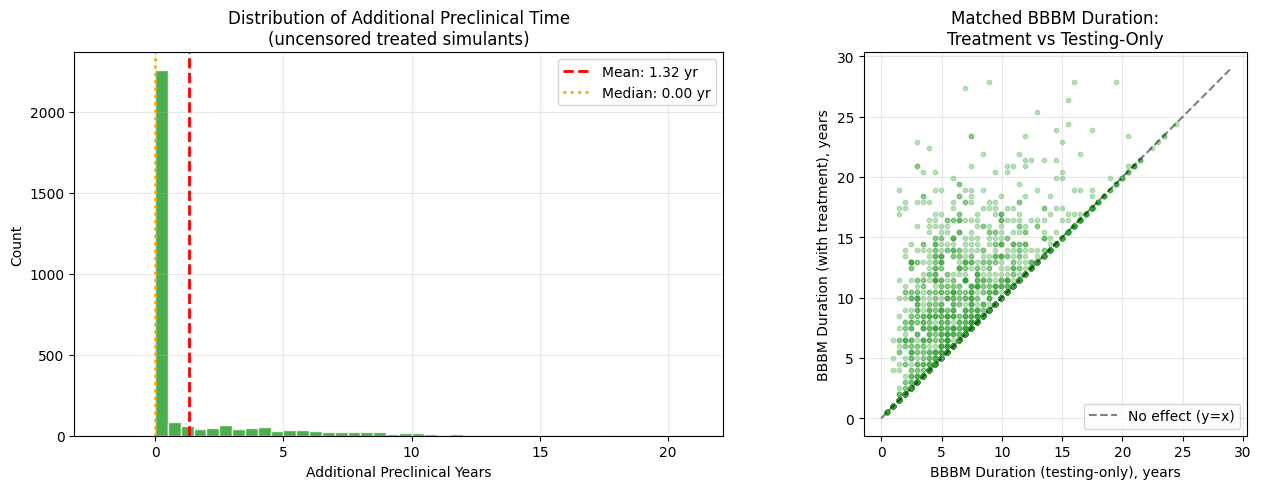

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: histogram of additional preclinical years
ax = axes[0]
bins = np.arange(-2, uncensored['additional_years'].max() + 1, 0.5)
ax.hist(uncensored['additional_years'], bins=bins, color='#2ca02c',
        edgecolor='white', alpha=0.85)
ax.axvline(x=uncensored['additional_years'].mean(), color='red',
           linestyle='--', linewidth=2, label=f'Mean: {uncensored["additional_years"].mean():.2f} yr')
ax.axvline(x=uncensored['additional_years'].median(), color='orange',
           linestyle=':', linewidth=2, label=f'Median: {uncensored["additional_years"].median():.2f} yr')
ax.set_xlabel('Additional Preclinical Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Additional Preclinical Time\n(uncensored treated simulants)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: BBBM duration comparison (scatter)
ax = axes[1]
ax.scatter(uncensored['dur_test_years'], uncensored['dur_treat_years'],
           alpha=0.3, s=10, color='#2ca02c')
lim = max(uncensored['dur_test_years'].max(), uncensored['dur_treat_years'].max()) + 1
ax.plot([0, lim], [0, lim], 'k--', alpha=0.5, label='No effect (y=x)')
ax.set_xlabel('BBBM Duration (testing-only), years')
ax.set_ylabel('BBBM Duration (with treatment), years')
ax.set_title('Matched BBBM Duration:\nTreatment vs Testing-Only', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 2. DALYs Averted per Treatment

DALYs averted = time shifted from a higher-disability state to a lower one.

- BBBM: DW = 0.000
- MCI: DW = 0.031
- Dementia: DW = 0.310

For each treated simulant, we compute the matched difference in time spent in each
state and weight by the disability weight.

In [7]:
# For per-simulant DALYs, we need time spent in each state.
# We tracked BBBM exit time. Time in MCI and Dementia is harder to get from
# exit tracking alone. Use the aggregate approach instead.

test_snaps = test_data['snapshots']
treat_snaps = treat_data['snapshots']
n = min(len(test_snaps), len(treat_snaps))

# Person-years in each state (each step = STEP_SIZE_YEARS)
for label, snaps in [('Testing Only', test_snaps), ('Testing+Treatment', treat_snaps)]:
    py_bbbm = (snaps['n_bbbm'] * STEP_SIZE_YEARS).sum()
    py_mci = (snaps['n_mci'] * STEP_SIZE_YEARS).sum()
    py_dem = (snaps['n_dementia'] * STEP_SIZE_YEARS).sum()
    total_dalys = py_bbbm * DW_BBBM + py_mci * DW_MCI + py_dem * DW_DEMENTIA
    print(f'{label}:')
    print(f'  BBBM person-years:     {py_bbbm:>12,.0f}')
    print(f'  MCI person-years:      {py_mci:>12,.0f}')
    print(f'  Dementia person-years:  {py_dem:>12,.0f}')
    print(f'  Total DALYs:           {total_dalys:>12,.1f}')
    print()

Testing Only:
  BBBM person-years:          424,556
  MCI person-years:           188,547
  Dementia person-years:       276,830
  Total DALYs:               91,662.2

Testing+Treatment:
  BBBM person-years:          429,526
  MCI person-years:           186,980
  Dementia person-years:       274,648
  Total DALYs:               90,937.2



In [8]:
# Compute differences
diff_bbbm_py = (treat_snaps['n_bbbm'].iloc[:n] - test_snaps['n_bbbm'].iloc[:n]).sum() * STEP_SIZE_YEARS
diff_mci_py = (test_snaps['n_mci'].iloc[:n] - treat_snaps['n_mci'].iloc[:n]).sum() * STEP_SIZE_YEARS
diff_dem_py = (test_snaps['n_dementia'].iloc[:n] - treat_snaps['n_dementia'].iloc[:n]).sum() * STEP_SIZE_YEARS

dalys_averted = diff_mci_py * DW_MCI + diff_dem_py * DW_DEMENTIA
n_treated = len(treat_data['treatment_start'])

print(f'=== Treatment Effect (aggregate, {test_snaps["year"].iloc[0]:.0f}-{test_snaps["year"].iloc[-1]:.0f}) ===')
print(f'  Additional BBBM person-years:       {diff_bbbm_py:>+10,.1f}')
print(f'  MCI person-years avoided:           {diff_mci_py:>+10,.1f}')
print(f'  Dementia person-years avoided:       {diff_dem_py:>+10,.1f}')
print(f'  Total DALYs averted:                {dalys_averted:>10,.1f}')
print(f'  Total simulants ever treated:       {n_treated:>10,}')
print(f'\n  DALYs averted per treatment:        {dalys_averted / n_treated:>10.4f}')
print(f'  Additional BBBM years per treatment: {diff_bbbm_py / n_treated:>10.2f}')
print(f'  MCI years avoided per treatment:    {diff_mci_py / n_treated:>10.2f}')
print(f'  Dementia years avoided per treatment: {diff_dem_py / n_treated:>10.2f}')

=== Treatment Effect (aggregate, 2023-2070) ===
  Additional BBBM person-years:         +4,970.9
  MCI person-years avoided:             +1,566.1
  Dementia person-years avoided:         +2,182.0
  Total DALYs averted:                     725.0
  Total simulants ever treated:            3,969

  DALYs averted per treatment:            0.1827
  Additional BBBM years per treatment:       1.25
  MCI years avoided per treatment:          0.39
  Dementia years avoided per treatment:       0.55


## 3. Does the Treatment Effect Change Over Time?

We analyze by treatment cohort — grouping treated simulants by the year they
started treatment. Earlier cohorts have had more time for the effect to play
out, but the treatment probability (and thus selection) differs by era.

In [9]:
# Per-cohort analysis (uncensored only for accuracy)
cohort_bins = list(range(2028, 2070, 5))  # 5-year cohorts
uncensored = matched[~matched['censored_treat'] & ~matched['censored_test']].copy()
uncensored['cohort'] = pd.cut(
    uncensored['treatment_year'],
    bins=cohort_bins,
    labels=[f'{y}-{y+4}' for y in cohort_bins[:-1]],
    right=False,
)

cohort_stats = uncensored.groupby('cohort', observed=True)['additional_years'].agg(
    ['count', 'mean', 'median', 'std']
).round(2)
cohort_stats.columns = ['N', 'Mean', 'Median', 'Std']
print('Additional Preclinical Years by Treatment Cohort (uncensored):')
print(cohort_stats.to_string())

Additional Preclinical Years by Treatment Cohort (uncensored):
             N  Mean  Median   Std
cohort                            
2028-2032   57  1.84     0.0  3.52
2033-2037  204  1.50     0.0  2.95
2038-2042  350  1.85     0.0  3.42
2043-2047  498  1.90     0.0  3.55
2048-2052  548  1.37     0.0  3.18
2053-2057  555  1.42     0.0  2.74
2058-2062  482  0.83     0.0  1.81
2063-2067  274  0.23     0.0  0.77


/tmp/ipykernel_38287/1725494133.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(cohort_groups, labels=cohort_labels, patch_artist=True)


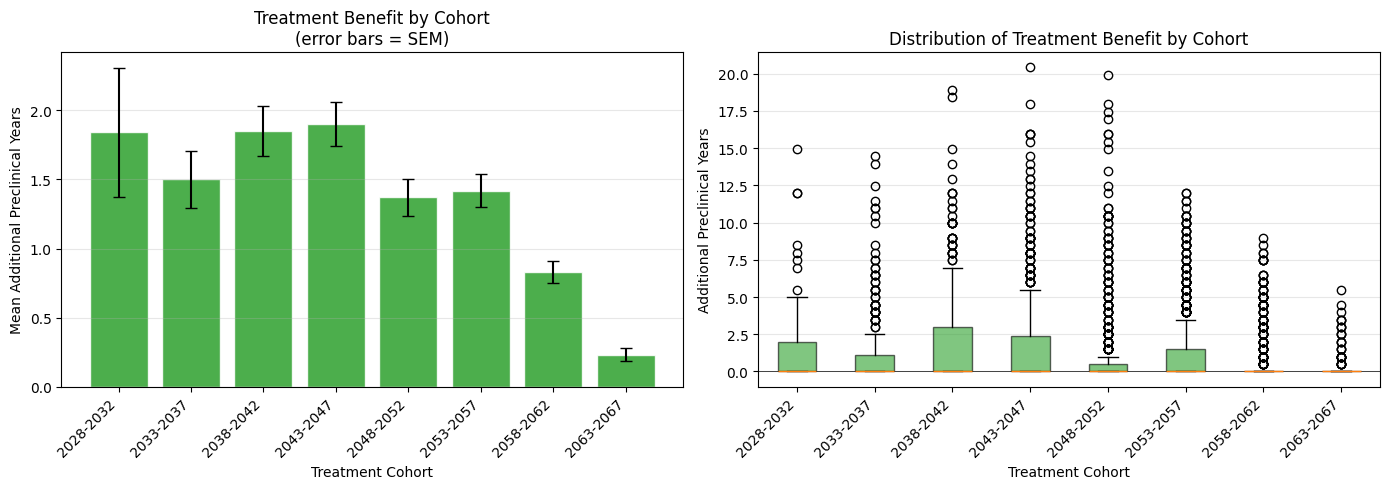

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: mean additional years by cohort
ax = axes[0]
valid = cohort_stats[cohort_stats['N'] >= 5]  # only plot cohorts with enough data
x = range(len(valid))
ax.bar(x, valid['Mean'], color='#2ca02c', alpha=0.85, edgecolor='white')
ax.errorbar(x, valid['Mean'], yerr=valid['Std'] / np.sqrt(valid['N']),
            fmt='none', color='black', capsize=4)
ax.set_xticks(x)
ax.set_xticklabels(valid.index, rotation=45, ha='right')
ax.set_xlabel('Treatment Cohort')
ax.set_ylabel('Mean Additional Preclinical Years')
ax.set_title('Treatment Benefit by Cohort\n(error bars = SEM)', fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

# Right: box plot by cohort
ax = axes[1]
cohort_groups = [group['additional_years'].values
                 for _, group in uncensored.groupby('cohort', observed=True)
                 if len(group) >= 5]
cohort_labels = [name for name, group in uncensored.groupby('cohort', observed=True)
                 if len(group) >= 5]
if cohort_groups:
    bp = ax.boxplot(cohort_groups, labels=cohort_labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('#2ca02c')
        patch.set_alpha(0.6)
    ax.set_xticklabels(cohort_labels, rotation=45, ha='right')
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Treatment Cohort')
ax.set_ylabel('Additional Preclinical Years')
ax.set_title('Distribution of Treatment Benefit by Cohort', fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Cumulative DALYs Averted Over Time

In [11]:
# Compute cumulative person-year differences and DALYs averted at each step
cum_data = []
cum_mci_py = 0
cum_dem_py = 0
cum_bbbm_py = 0

for i in range(n):
    diff_bbbm = (treat_snaps['n_bbbm'].iloc[i] - test_snaps['n_bbbm'].iloc[i]) * STEP_SIZE_YEARS
    diff_mci = (test_snaps['n_mci'].iloc[i] - treat_snaps['n_mci'].iloc[i]) * STEP_SIZE_YEARS
    diff_dem = (test_snaps['n_dementia'].iloc[i] - treat_snaps['n_dementia'].iloc[i]) * STEP_SIZE_YEARS
    cum_bbbm_py += diff_bbbm
    cum_mci_py += diff_mci
    cum_dem_py += diff_dem
    cum_data.append({
        'year': test_snaps['year'].iloc[i],
        'cum_bbbm_py': cum_bbbm_py,
        'cum_mci_py_avoided': cum_mci_py,
        'cum_dem_py_avoided': cum_dem_py,
        'cum_dalys_averted': cum_mci_py * DW_MCI + cum_dem_py * DW_DEMENTIA,
    })

cum_df = pd.DataFrame(cum_data)

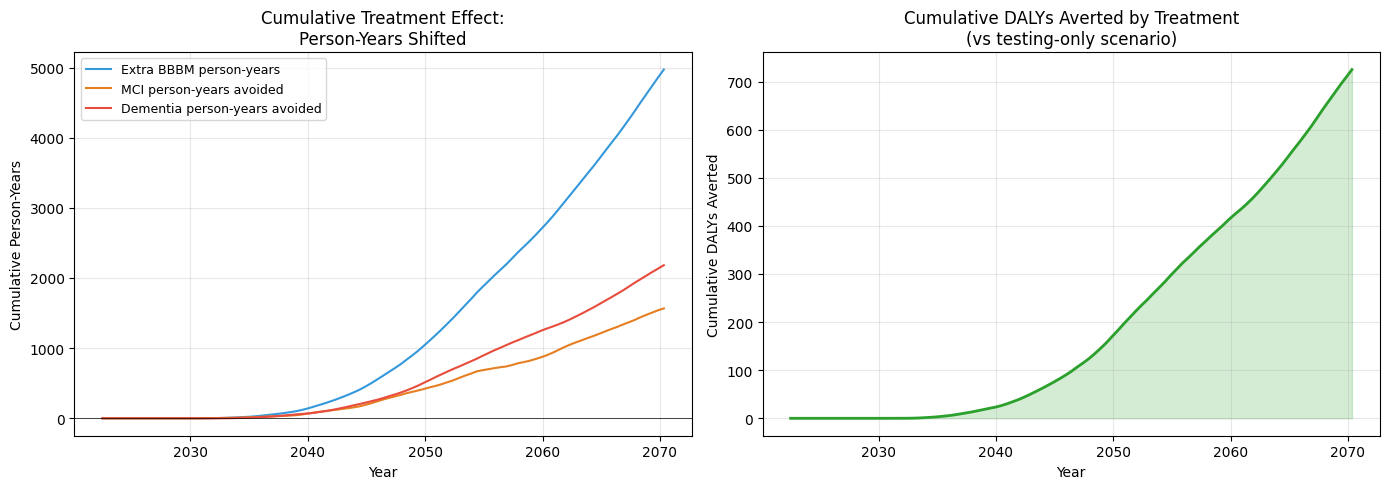

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: cumulative person-years shifted
ax = axes[0]
ax.plot(cum_df['year'], cum_df['cum_bbbm_py'], label='Extra BBBM person-years',
        color='#3498db', linewidth=1.5)
ax.plot(cum_df['year'], cum_df['cum_mci_py_avoided'], label='MCI person-years avoided',
        color='#e67e22', linewidth=1.5)
ax.plot(cum_df['year'], cum_df['cum_dem_py_avoided'], label='Dementia person-years avoided',
        color='#e74c3c', linewidth=1.5)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Person-Years')
ax.set_title('Cumulative Treatment Effect:\nPerson-Years Shifted', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Right: cumulative DALYs averted
ax = axes[1]
ax.plot(cum_df['year'], cum_df['cum_dalys_averted'], color='#2ca02c', linewidth=2)
ax.fill_between(cum_df['year'], 0, cum_df['cum_dalys_averted'],
                color='#2ca02c', alpha=0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative DALYs Averted')
ax.set_title('Cumulative DALYs Averted by Treatment\n(vs testing-only scenario)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Per-Treatment DALYs Over Time

Does a treatment given in 2035 avert more or fewer DALYs than one in 2050?
We approximate this by looking at the marginal DALY rate (DALYs averted per step)
divided by the number of simulants under active treatment effect.

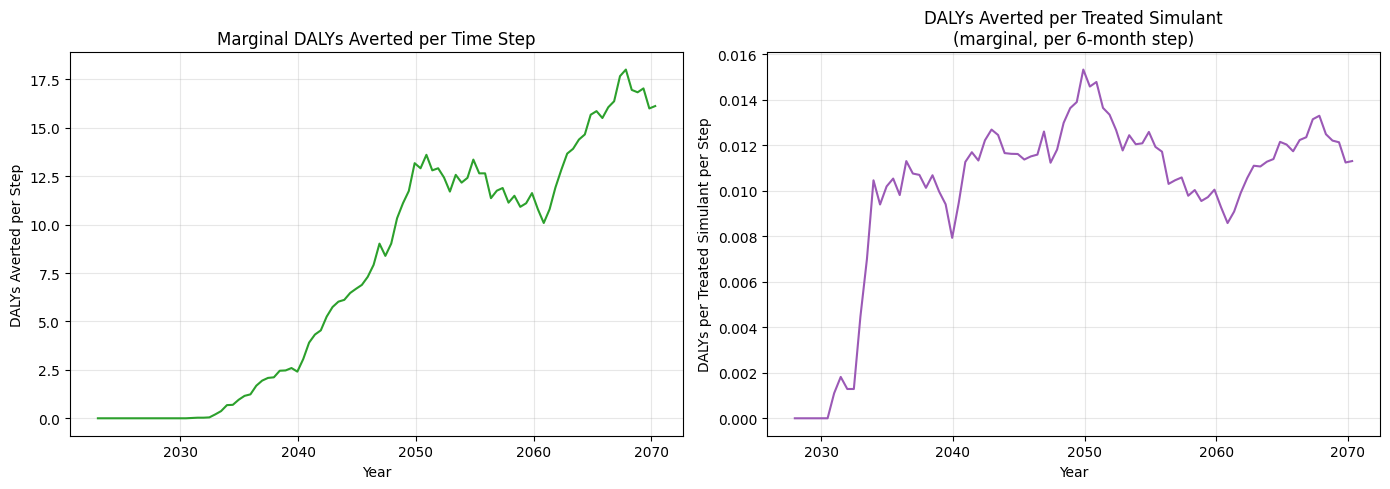

In [13]:
# Marginal DALY rate per step, normalized by number under treatment effect
marginal = []
for i in range(1, n):
    step_dalys = (cum_df['cum_dalys_averted'].iloc[i] -
                  cum_df['cum_dalys_averted'].iloc[i-1])
    n_effect = treat_snaps['n_treatment_effect'].iloc[i] + treat_snaps['n_waning_effect'].iloc[i]
    marginal.append({
        'year': cum_df['year'].iloc[i],
        'step_dalys': step_dalys,
        'n_under_effect': n_effect,
        'dalys_per_treated_per_step': step_dalys / max(n_effect, 1) if n_effect > 0 else np.nan,
    })
marg_df = pd.DataFrame(marginal)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: marginal DALYs averted per step
ax = axes[0]
ax.plot(marg_df['year'], marg_df['step_dalys'], color='#2ca02c', linewidth=1.5)
ax.set_xlabel('Year')
ax.set_ylabel('DALYs Averted per Step')
ax.set_title('Marginal DALYs Averted per Time Step', fontsize=12)
ax.grid(True, alpha=0.3)

# Right: DALYs per treated simulant per step
ax = axes[1]
valid = marg_df.dropna(subset=['dalys_per_treated_per_step'])
ax.plot(valid['year'], valid['dalys_per_treated_per_step'],
        color='#9b59b6', linewidth=1.5)
ax.set_xlabel('Year')
ax.set_ylabel('DALYs per Treated Simulant per Step')
ax.set_title('DALYs Averted per Treated Simulant\n(marginal, per 6-month step)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [14]:
uncensored = matched[~matched['censored_treat'] & ~matched['censored_test']]

print('=' * 60)
print('TREATMENT EFFECT SUMMARY')
print('=' * 60)
print(f'Simulation period: 2022-{TARGET_YEAR}')
print(f'Population: {POPULATION_SIZE:,}')
print(f'Treatment RR: {TREATMENT_RR:.3f}')
print(f'Disability weights: BBBM={DW_BBBM}, MCI={DW_MCI}, Dementia={DW_DEMENTIA}')
print()
print(f'--- Per-Simulant (matched comparison, n={len(uncensored)} uncensored) ---')
print(f'  Additional preclinical years (mean):   {uncensored["additional_years"].mean():.2f}')
print(f'  Additional preclinical years (median): {uncensored["additional_years"].median():.2f}')
print()
print(f'--- Aggregate (scenario comparison) ---')
print(f'  Total treatments given:               {n_treated:,}')
print(f'  Additional BBBM person-years:          {diff_bbbm_py:+,.1f}')
print(f'  MCI person-years avoided:             {diff_mci_py:+,.1f}')
print(f'  Dementia person-years avoided:         {diff_dem_py:+,.1f}')
print(f'  Total DALYs averted:                  {dalys_averted:,.1f}')
print(f'  DALYs averted per treatment:          {dalys_averted / n_treated:.4f}')
print()
print(f'--- By Treatment Cohort ---')
print(cohort_stats.to_string())

TREATMENT EFFECT SUMMARY
Simulation period: 2022-2070
Population: 10,000
Treatment RR: 0.528
Disability weights: BBBM=0.0, MCI=0.031, Dementia=0.31

--- Per-Simulant (matched comparison, n=3032 uncensored) ---
  Additional preclinical years (mean):   1.32
  Additional preclinical years (median): 0.00

--- Aggregate (scenario comparison) ---
  Total treatments given:               3,969
  Additional BBBM person-years:          +4,970.9
  MCI person-years avoided:             +1,566.1
  Dementia person-years avoided:         +2,182.0
  Total DALYs averted:                  725.0
  DALYs averted per treatment:          0.1827

--- By Treatment Cohort ---
             N  Mean  Median   Std
cohort                            
2028-2032   57  1.84     0.0  3.52
2033-2037  204  1.50     0.0  2.95
2038-2042  350  1.85     0.0  3.42
2043-2047  498  1.90     0.0  3.55
2048-2052  548  1.37     0.0  3.18
2053-2057  555  1.42     0.0  2.74
2058-2062  482  0.83     0.0  1.81
2063-2067  274  0.23     